# Roll decay db added inertia check
Accordin to SSPA rule of thumb roll gyradii should increase 5-15% during a roll decay test.
The present identification techniques as well as the meta data in the db will be checked with this rule.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
pd.set_option("display.max_columns", None)
import numpy as np
import os
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 9

import data
import copy
from mdldb.mdl_db import MDLDataBase
from mdldb.tables import Base, Project, Model, LoadingCondition, Run, RolldecayLinear, RolldecayDirect, RolldecayNorwegian
from mdldb import mdl_to_evaluation
from evaluation.run_dynamic import RunDynamic
from evaluation.run_manoeuvring import RunZigZag

from rolldecayestimators.direct_estimator import DirectEstimator
from rolldecayestimators.direct_linear_estimator import DirectLinearEstimator
from rolldecayestimators.norwegian_estimator import NorwegianEstimator
from rolldecayestimators.transformers import CutTransformer, LowpassFilterDerivatorTransformer, ScaleFactorTransformer, OffsetTransformer
#from rolldecay.equations_lambdify import calculate_acceleration, calculate_velocity
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from rolldecayestimators import equations
from rolldecayestimators import symbols

import signal_lab


c:\dev\rolldecay\venv\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///' + data.mdl_db_path)
db = MDLDataBase(engine=engine)

In [4]:
lowpass_filter = LowpassFilterDerivatorTransformer(cutoff=1, minimum_score=0.99)
scaler = ScaleFactorTransformer(scale_factor=None)  # dummy value None for now
cutter = CutTransformer(phi_max=np.deg2rad(10), phi_min=np.deg2rad(0.5))

In [5]:
steps = [
    ('filter',lowpass_filter),
    ('scaler',scaler),
    ('cutter', cutter), 
    #('offset_transformer',offset_transformer),
]

transformer = Pipeline(steps)

In [6]:
sql="""
SELECT * from
rolldecay_norwegian
INNER JOIN run
ON rolldecay_norwegian.run_id == run.id
    INNER JOIN loading_conditions
    ON (run.loading_condition_id == loading_conditions.id)
        INNER JOIN models
        ON run.model_number == models.model_number
            INNER JOIN ships
            ON models.ship_name == ships.name

"""
df_rolldecay = pd.read_sql(sql, con=engine, index_col='run_id',)
df_rolldecay = df_rolldecay.loc[:,~df_rolldecay.columns.duplicated()]

In [7]:
#mask = df_rolldecay[['KXX','gm','beam','lpp']].notnull().all(axis=1)
mask = df_rolldecay[['beam','lpp']].notnull().all(axis=1)
df_rolldecay=df_rolldecay.loc[mask].copy()

In [8]:
df_rolldecay.sort_values(by='date',ascending=False, inplace=True)
df_rolldecay.head()

,d,mean_damping,omega0,score,zeta,id,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA
run_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20749,0.253485,0.008750,0.454435,0.988973,0.004110,20749,20168119,221,25,1,M5045-01-A,M5045-01-A,158,20168119-ser221-k025-100hz.asc,4.0,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20168119-ser221-k...,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-03-28,roll decay,MDL,None,None,15.0,129.34,12.25,6.23,NaN,15.0,15.0,NaN,NaN,NaN,NaN,NaN,129473.0,NaN,NaN,55.0,242.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
20750,0.249308,0.008797,0.454313,0.986808,0.004495,20750,20168119,221,26,1,M5045-01-A,M5045-01-A,158,20168119-ser221-k026-100hz.asc,4.0,Kursstyrning Roll decay och Rodret fysiskt Nol...,N:\Gamla_Projekt\ascii_files\20168119-ser221-k...,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-03-28,roll decay,MDL,None,None,15.0,129.34,12.25,6.23,NaN,15.0,15.0,NaN,NaN,NaN,NaN,NaN,129473.0,NaN,NaN,55.0,242.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
20736,0.240816,0.006600,0.454712,0.993362,0.002723,20736,20168119,221,12,1,M5045-01-A,M5045-01-A,158,20168119-ser221-k012-100hz.asc,1.0,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20168119-ser221-k...,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-03-27,roll decay,MDL,None,None,15.0,129.34,12.25,6.23,NaN,15.0,15.0,NaN,NaN,NaN,NaN,NaN,129473.0,NaN,NaN,55.0,242.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
20803,0.594251,0.105135,0.594831,0.997333,0.093054,20803,30168001,1,33,1,M5046-01-A,M5046-01-A,162,30168001-ser001-k033-100hz.asc,10.0,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\30168001-ser001-k...,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-03-11,roll decay,MDL,None,None,5.3,-2.29,7.51,2.60,NaN,5.3,5.3,NaN,NaN,NaN,NaN,NaN,6661.0,NaN,NaN,34.0,110.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
20805,0.885781,0.046266,0.597013,0.987449,0.031158,20805,30168001,1,35,1,M5046-01-A,M5046-01-A,162,30168001-ser001-k035-100hz.asc,6.0,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\30168001-ser001-k...,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-03-11,roll decay,MDL,None,None,5.3,-2.29,7.51,2.60,NaN,5.3,5.3,NaN,NaN,NaN,NaN,NaN,6661.0,NaN,NaN,34.0,110.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN


In [9]:
mask = df_rolldecay['ship_speed']==1
df_zero_speed = df_rolldecay.loc[mask].copy()
df_zero_speed.head()

,d,mean_damping,omega0,score,zeta,id,project_number,series_number,run_number,test_number,model_number,ship_name,loading_condition_id,ascii_name,ship_speed,comment,file_path_ascii,file_path_log,file_path_hdf5,date,test_type,facility,angle1,angle2,name,lcg,kg,gm,CW,TF,TA,BWL,KXX,KZZ,BTT1,CP,Volume,A0,RH,scale_factor,lpp,beam,ABULB,BKX,TWIN,DCLR,VDES,RHBL,ASKEG,PD,ARH,CFP,AIX,PDTDES,RTYPE,SFP,BKL,BKB,PROT,D,LSKEG,RR,XSKEG,NDES,AR,BR,BRA,IRUD,PTYPE,XRUD,AI,HSKEG,RSKEG,LOA
run_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
20736,0.240816,0.006600,0.454712,0.993362,0.002723,20736,20168119,221,12,1,M5045-01-A,M5045-01-A,158,20168119-ser221-k012-100hz.asc,1.0,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\20168119-ser221-k...,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-03-27,roll decay,MDL,None,None,15.0,129.34,12.25,6.23,NaN,15.0,15.0,NaN,NaN,NaN,NaN,NaN,129473.0,NaN,NaN,55.0,242.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
20781,1.644655,0.045599,0.604526,0.989600,0.018753,20781,30168001,1,11,1,M5046-01-A,M5046-01-A,162,30168001-ser001-k011-100hz.asc,1.0,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\30168001-ser001-k...,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-03-10,roll decay,MDL,None,None,5.3,-2.29,7.51,2.60,NaN,5.3,5.3,NaN,NaN,NaN,NaN,NaN,6661.0,NaN,NaN,34.0,110.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
21201,1.086977,0.079675,0.603768,0.995140,0.059421,21201,30168001,18,27,1,M5046-01-A,M5046-01-A,162,30168001-ser018-k027-100hz.asc,1.0,Kursstyrning Roll decay 3.0,N:\Gamla_Projekt\ascii_files\30168001-ser018-k...,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-03-08,roll decay,MDL,None,None,5.3,-2.29,7.51,2.60,NaN,5.3,5.3,NaN,NaN,NaN,NaN,NaN,6661.0,NaN,NaN,34.0,110.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
21194,1.053787,0.078349,0.606507,0.994448,0.059492,21194,30168001,18,20,1,M5046-01-A,M5046-01-A,162,30168001-ser018-k020-100hz.asc,1.0,Kursstyrning Roll decay,N:\Gamla_Projekt\ascii_files\30168001-ser018-k...,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-03-08,roll decay,MDL,None,None,5.3,-2.29,7.51,2.60,NaN,5.3,5.3,NaN,NaN,NaN,NaN,NaN,6661.0,NaN,NaN,34.0,110.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
21195,0.910176,0.077343,0.605634,0.988737,0.059363,21195,30168001,18,21,1,M5046-01-A,M5046-01-A,162,30168001-ser018-k021-100hz.asc,1.0,Kursstyrning Roll decay 2.0,N:\Gamla_Projekt\ascii_files\30168001-ser018-k...,\\sspa.local\gbg\MDLdata\Gamla_Projekt\Gamla_P...,None,2017-03-08,roll decay,MDL,None,None,5.3,-2.29,7.51,2.60,NaN,5.3,5.3,NaN,NaN,NaN,NaN,NaN,6661.0,NaN,NaN,34.0,110.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN


In [10]:
models = db.session.query(Model).filter(Model.model_number=='M3613-A').all()

In [11]:
len(models)

1

In [12]:
model = models[0]
model.loading_conditions

In [13]:
model.loading_conditions[0].Volume

119034.0

In [14]:
model.loading_conditions[0].TA

11.7

In [15]:
model.loading_conditions[1].Volume

93575.0

In [16]:
model.loading_conditions[1].TA

9.4

In [17]:
project = db.session.query(Project).get(20157375)
ship=project.ships[0]
model=ship.models[0]
model.model_number

'M3613-A'

In [18]:
model.loading_conditions[0].model.model_number

'M3613-A'

In [19]:
model.loading_conditions[1].model.model_number

'M3613-A'

In [20]:
meta_data = df_zero_speed.loc[18120]
meta_data

d                                                                0.300234
mean_damping                                                   0.00773212
omega0                                                            0.40306
score                                                            0.997735
zeta                                                           0.00384774
id                                                                  18120
project_number                                                   20157375
series_number                                                          11
run_number                                                              6
test_number                                                             1
model_number                                                      M3613-A
ship_name                                                         M3613-A
loading_condition_id                                                  133
ascii_name                            

In [21]:
run_id=meta_data.name

In [22]:
run_id

18120

In [23]:
db_run = db.session.query(Run).get(int(run_id))
db_run

In [24]:
def load(db_run):
    
    ascii_file = db_run.load()
    df_raw = ascii_file.channels
    
    df = signal_lab.mdl_to_evaluation.do_transforms(df=df_raw)
    df.rename(columns={'MA/Roll':'phi'}, inplace=True)
    
    return df

In [25]:
db_run.file_path_ascii

'N:\\Gamla_Projekt\\ascii_files\\20157375-ser011-k006-100hz.asc'

In [26]:
db_run.project.project_path

'S:\\2015\\20157375-DSME-174k-LNGC'

In [27]:
loading_condition = db_run.loading_condition
loading_condition.TF

9.4

In [28]:
loading_condition.TA

9.4

In [29]:
loading_condition.name

'9.4'

In [30]:
db_run.model_number

'M3613-A'

In [31]:
loading_condition.Volume

93575.0

In [32]:
loading_condition.model.model_number

'M3613-A'

In [33]:
df_raw = load(db_run)

c:\dev\evaluation\signal_lab\mdl_to_evaluation.py:103: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_.units = units


In [101]:
transformer['scaler'].scale_factor = db_run.model.scale_factor
transformer.fit(df_raw)
df = transformer.transform(df_raw)

In [29]:
db_run.model.scale_factor

55.0

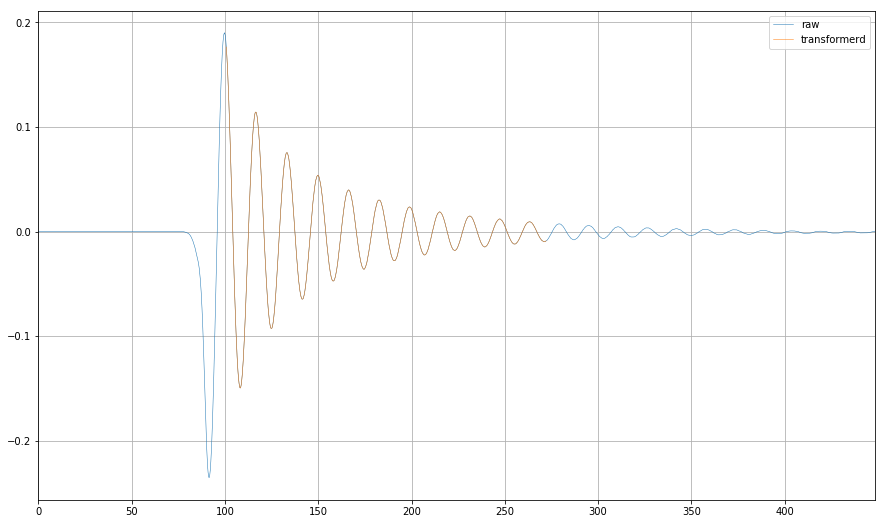

In [13]:
fig,ax = plt.subplots()

x = df_raw.index*np.sqrt(db_run.model.scale_factor)
y = df_raw['phi']
ax.plot(x,y, label='raw')
df.plot(y='phi',ax=ax, label='transformerd');
ax.grid(True)
ax.legend();


In [14]:
df.head()

,prop.tr sb,prop.tr bb,mom sb,mom bb,hj. mom,acc x,acc y1 f,acc y2 a,acc z1 bb f,acc z2 a,acc z3 sb f,delta,varv sb,varv bb,Carriage/Xp_west,Carriage/Xp_east,Carriage/Yp,Carriage/dXp,Carriage/Psip,MA/Alfa,MA/Beta,MA/Gamma,MA/Delta,MA/Torkorr,phi,MA/Pitch,våghöjd pg,phi_filtered,phi1d,phi2d
100.711975,-0.024546,0.177163,-0.035933,0.032627,-0.006755,-0.017191,-1.97354,-1.90668,0.401400,0.180401,-0.062613,-0.000511,0.000000,-0.306796,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001222,-0.022166,0.002880,-0.005061,-1.0,0.176453,-0.001484,-0.000184,0.176929,-0.025053,-0.023042
100.860299,0.037480,0.235301,-0.033163,0.032627,0.008550,-0.000435,-1.90310,-1.86985,0.379844,0.212840,-0.042358,0.000178,1.227180,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001134,-0.022166,0.002967,-0.004800,-1.0,0.172526,-0.001484,-0.000184,0.172960,-0.028413,-0.022239
101.008623,-0.024546,0.235301,-0.033163,0.035461,0.016202,-0.000435,-1.85027,-1.83302,0.379844,0.212840,-0.082867,-0.000511,1.533980,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001134,-0.022253,0.003054,-0.004538,-1.0,0.167813,-0.001484,-0.000184,0.168501,-0.031650,-0.021383
101.156947,-0.024546,0.235301,-0.035933,0.032627,0.008550,0.016320,-1.81505,-1.75936,0.358289,0.212840,-0.042358,0.000522,0.306796,0.306796,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001047,-0.022253,0.003142,-0.004276,-1.0,0.162839,-0.001396,-0.000184,0.163571,-0.034756,-0.020479
101.305271,-0.024546,0.235301,-0.035933,0.035461,-0.006755,-0.017191,-1.76222,-1.70412,0.336733,0.196621,-0.062613,0.000866,-0.306796,-0.306796,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001047,-0.022253,0.003142,-0.004102,-1.0,0.157429,-0.001396,-0.000184,0.158190,-0.037725,-0.019528


In [15]:
direct_linear_estimator = DirectLinearEstimator()
direct_linear_estimator.fit(X=df)
direct_linear_estimator.score()

0.9734392155501559

In [16]:
direct_linear_estimator.omega0

0.3851174551953201

In [28]:
direct_linear_estimator.parameters

{'omega0': 0.3770702256366647, 'zeta': 0.06902053823081644}

In [27]:
2*np.pi/direct_linear_estimator.omega0

16.314984486987072

In [24]:
2*np.pi/(2*direct_linear_estimator.X_amplitudes.index)

Float64Index([ 0.3778449812220358, 0.37516997250541984,  0.3778449812220364,
               0.3778449812220364, 0.37987640585226096,  0.3805584101715661,
               0.3826191957862147, 0.38261919578621206,  0.3847024218975719,
              0.38470242189757325,  0.3875156023136416,   0.387515602313643,
              0.38822533784901453, 0.38965263688522406,  0.3903702292183459,
              0.39109046949365783,  0.3918133723947565, 0.39326722535354675,
               0.3939982053263242],
             dtype='float64')

In [26]:
direct_linear_estimator.X_amplitudes.index

Float64Index([8.314501474729596,  8.37378490770449, 8.314501474729582,
              8.314501474729582,  8.27003889999844, 8.255218041754688,
              8.210755467023489, 8.210755467023546, 8.166292892292347,
              8.166292892292319, 8.107009459317453, 8.107009459317425,
               8.09218860107373, 8.062546884586283,  8.04772602634256,
              8.032905168098807, 8.018084309855055, 7.988442593367665,
              7.973621735123913],
             dtype='float64')

In [25]:
direct_linear_estimator.X_zerocrossings

,prop.tr sb,prop.tr bb,mom sb,mom bb,hj. mom,acc x,acc y1 f,acc y2 a,acc z1 bb f,acc z2 a,acc z3 sb f,delta,varv sb,varv bb,Carriage/Xp_west,Carriage/Xp_east,Carriage/Yp,Carriage/dXp,Carriage/Psip,MA/Alfa,MA/Beta,MA/Gamma,MA/Delta,MA/Torkorr,phi,MA/Pitch,våghöjd pg,phi_filtered,phi1d,phi2d,omega0
108.166867,-0.024546,0.177163,-0.035210,0.032627,-0.012245,-0.017191,1.649566,1.592140,-0.153423,0.103536,0.316941,-0.000167,0.000000,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001571,-0.020857,-0.005631,-0.004693,0.0,-0.149442,-0.000087,-0.000684,-0.148678,-0.000075,0.021040,0.385117
116.481369,-0.001873,0.235301,-0.035933,0.032627,-0.024673,0.005690,-1.281154,-1.257213,0.228955,0.083085,-0.123376,-0.000041,1.870425,0.209472,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001484,-0.020159,-0.003054,-0.008612,-1.0,0.114232,-0.000785,-0.001084,0.113935,0.000099,-0.016474,0.385117
124.855154,-0.038610,0.222120,-0.035933,0.030437,-0.031293,-0.030148,1.047435,0.974390,-0.137491,0.034427,0.185035,0.000178,1.423426,-0.069559,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001396,-0.019111,-0.007223,-0.006351,0.0,-0.092570,0.000175,-0.000384,-0.092460,-0.000017,0.013051,0.385117
133.169655,0.016345,0.235301,-0.035461,0.032627,0.001549,-0.000435,-0.843487,-0.801789,0.121177,0.042717,-0.059162,0.000463,1.833959,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001222,-0.018413,-0.005338,-0.008392,-1.0,0.075471,-0.000175,-0.000484,0.075376,0.000008,-0.010935,0.385117
141.484156,-0.024546,0.228673,-0.038387,0.032627,-0.001284,-0.017191,0.707227,0.706131,-0.070366,0.005687,0.139934,-0.000285,1.630910,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001222,-0.017541,-0.008368,-0.007243,0.0,-0.064490,0.000262,-0.000484,-0.064483,-0.000016,0.009169,0.385117
149.754195,-0.046716,0.197943,-0.035933,0.033640,-0.029713,0.010331,-0.611260,-0.557145,0.113473,0.013582,-0.069852,-0.000388,0.306796,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001222,-0.017279,-0.006807,-0.008727,-1.0,0.053899,0.000000,-0.000284,0.053669,0.000033,-0.007890,0.385117
158.009413,-0.043108,0.235301,-0.035104,0.032627,-0.025104,-0.012177,0.491889,0.505667,-0.051268,0.011695,0.058915,0.000660,0.306796,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001134,-0.017191,-0.008814,-0.007941,0.0,-0.047211,0.000262,-0.000284,-0.047327,-0.000056,0.006791,0.385117
166.220169,-0.086573,0.235301,-0.034115,0.032627,-0.001613,-0.000435,-0.418342,-0.433492,0.063922,0.034427,-0.029068,0.000178,0.000000,-0.306796,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001134,-0.017366,-0.007330,-0.009076,-1.0,0.039851,0.000000,-0.000284,0.039715,0.000081,-0.005932,0.385117
174.430924,-0.087383,0.177922,-0.033199,0.035424,-0.002929,-0.000217,0.420989,0.358829,-0.051549,0.001988,0.039189,0.000178,0.004004,0.000000,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001134,-0.018153,-0.008465,-0.008465,0.0,-0.035954,0.000262,-0.000284,-0.035811,-0.000045,0.005182,0.385117
182.597217,-0.086573,0.231220,-0.035933,0.032429,-0.028907,-0.000435,-0.320652,-0.323003,0.076553,0.001988,-0.040936,-0.000167,0.000000,0.086133,-9.4645,-9.4641,0.0469,-0.0225,0.01104,0.001134,-0.018850,-0.006981,-0.009157,-1.0,0.030194,0.000087,-0.000284,0.030256,0.000065,-0.004591,0.385117


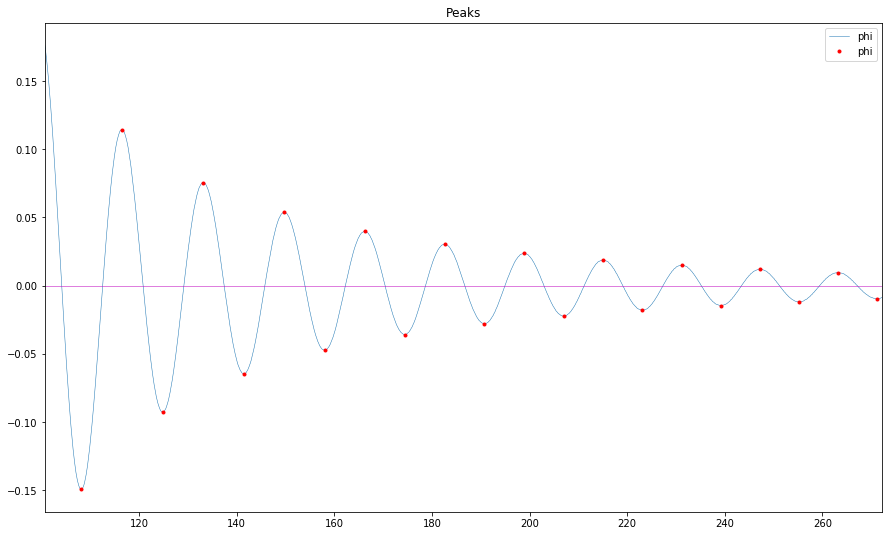

In [18]:
direct_linear_estimator.calculate_amplitudes_and_damping()
direct_linear_estimator.plot_peaks()

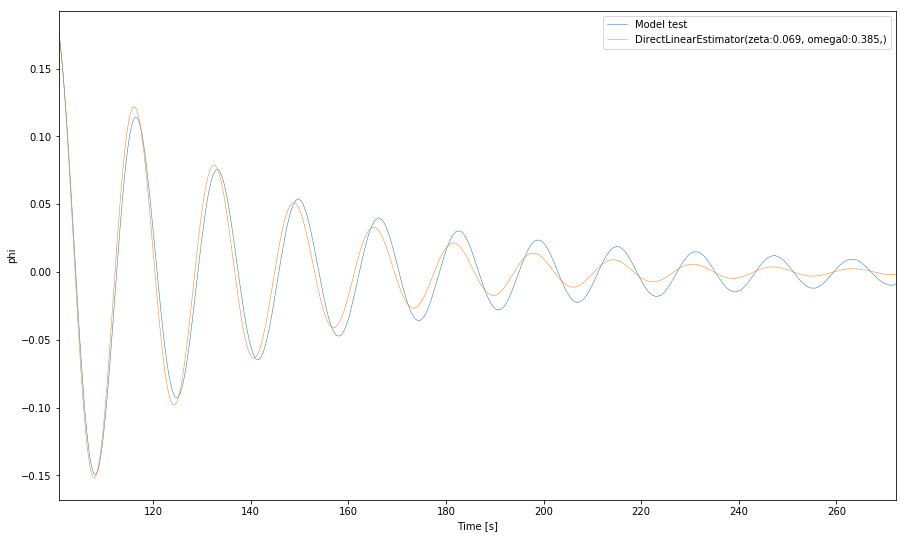

In [647]:
direct_linear_estimator.plot_fit()

In [648]:
from sympy.physics.vector.printing import vpprint, vlatex
from IPython.display import display, Math, Latex

In [649]:
import sympy as sp
from rolldecay.symbols import *
dGM = sp.symbols('dGM')
#lhs = phi_dot_dot + 2*zeta*omega0*phi_dot + omega0**2*phi + dGM*phi*sp.Abs(phi)
lhs = phi_dot_dot + 2*zeta*omega0*phi_dot + omega0**2*(phi+dGM*phi*sp.Abs(phi)) + d*sp.Abs(phi_dot)*phi_dot

roll_diff_equation_linear = sp.Eq(lhs=lhs,rhs=0)

latex = vlatex(roll_diff_equation_linear)
display(Math(latex))


<IPython.core.display.Math object>

In [650]:
from rolldecayestimators.substitute_dynamic_symbols import lambdify
acceleration = sp.Eq(lhs=phi,rhs=sp.solve(roll_diff_equation_linear,phi.diff().diff())[0])
calculate_acceleration = lambdify(acceleration.rhs)

In [651]:
calculate_acceleration

<function _lambdifygenerated(d, dGM, omega0, phi, phi1d, zeta)>

In [652]:
from scipy.integrate import odeint

class DirectEstimatorImproved(DirectEstimator):
    """ A template estimator to be used as a reference implementation.

    For more information regarding how to build your own estimator, read more
    in the :ref:`User Guide <user_guide>`.

    Parameters
    ----------
    demo_param : str, default='demo_param'
        A parameter used for demonstation of how to pass and store paramters.
    """

    @staticmethod
    def equation(df, omega0, zeta, dGM, d):
        
        phi = df['phi']
        phi1d = df['phi1d']
        
        phi2d = calculate_acceleration(omega0=omega0, phi=phi, phi1d=phi1d, zeta=zeta, dGM=dGM, d=d)
        
        return phi2d
     
    @staticmethod
    def roll_decay_time_step(states, t, omega0, zeta, dGM, d):
        # states:
        # [phi,phi1d]
    
        phi_old = states[0]
        p_old = states[1]
    
        phi1d = p_old
        phi2d = calculate_acceleration(omega0=omega0, phi=phi_old, phi1d=p_old, zeta=zeta, dGM=dGM, d=d)
    
        d_states_dt = np.array([phi1d, phi2d])
    
        return d_states_dt
    
    def simulate(self,t :np.ndarray, phi0 :float, phi1d0 :float,omega0:float, zeta:float, dGM:float, d:float)->pd.DataFrame:
        """
        Simulate a roll decay test using the quadratic method.
        :param t: time vector to be simulated [s]
        :param phi0: initial roll angle [rad]
        :param phi1d0: initial roll speed [rad/s]
        :param omega0: roll natural frequency[rad/s]
        :param d: quadratic roll damping [-]
        :param zeta:linear roll damping [-]
        :return: pandas data frame with time series of 'phi' and 'phi1d'
        """
    
        states0 = [phi0, phi1d0]
        args = (
            omega0,
            zeta,
            dGM,
            d,
        )
        states = odeint(func=self.roll_decay_time_step, y0=states0, t=t, args=args)
    
        df = pd.DataFrame(index=t)
    
        df['phi'] = states[:, 0]
        df['phi1d'] = states[:,1]
    
        return df
    
    def do_simulation(self, t, phi0, phi1d0):
        return self.simulate(t=t, **self.parameters, phi0=phi0, phi1d0=phi1d0)

In [653]:
estimator = DirectEstimatorImproved()
estimator.fit(X=df)
estimator.score()

0.996484346087091

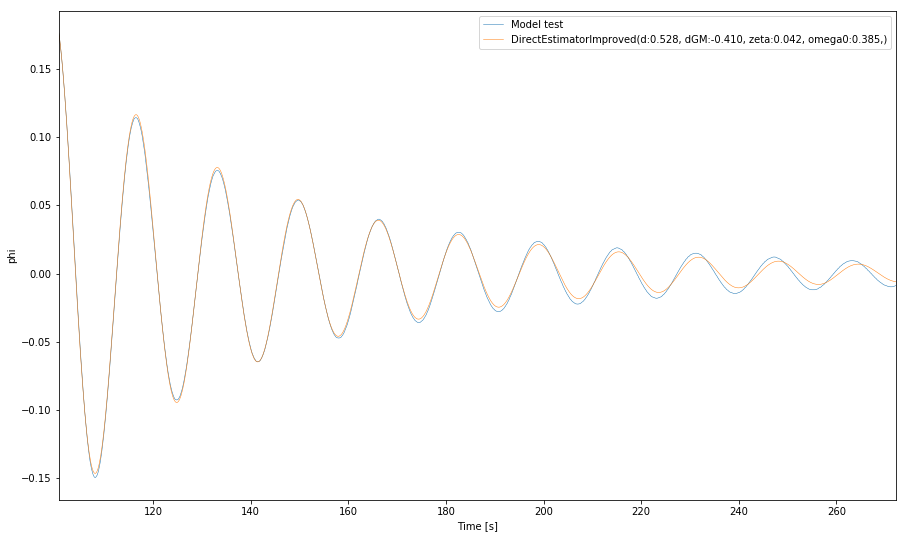

In [654]:
estimator.plot_fit()

In [617]:
estimator.parameters

{'d': 0.3075936246695699,
 'dGM': 0.06051461235552046,
 'omega0': 0.3994386911611813,
 'zeta': 0.0030446990057335895}

Text(0.5, 1.0, 'Natural frequency $ \\omega_0 $ for each oscillation')

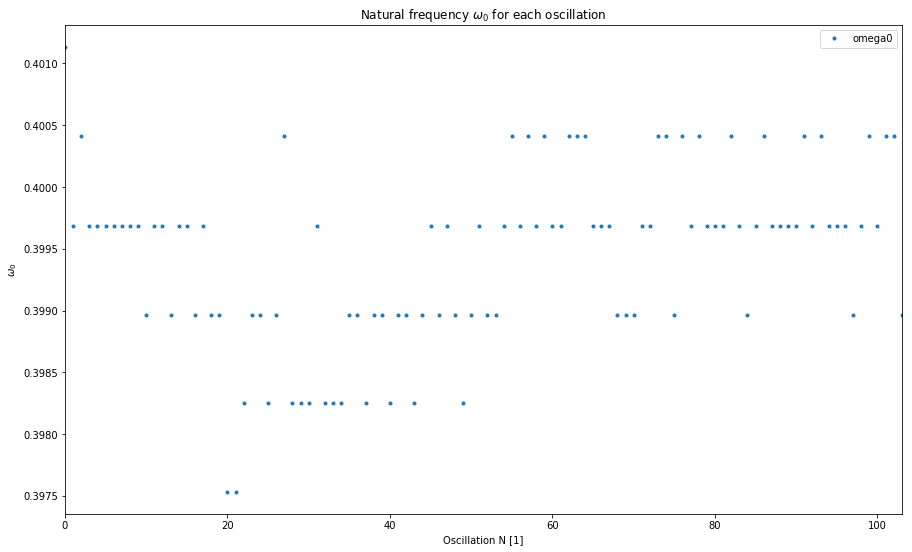

In [618]:
fig,ax=plt.subplots()
X_amplitudes = direct_linear_estimator.X_amplitudes.copy()
X_amplitudes.reset_index(inplace=True)
X_amplitudes.plot(y='omega0', style='.', ax=ax)
ax.set_xlabel('Oscillation N [1]')
ax.set_ylabel('$\omega_0$')
ax.set_title('Natural frequency $ \omega_0 $ for each oscillation')

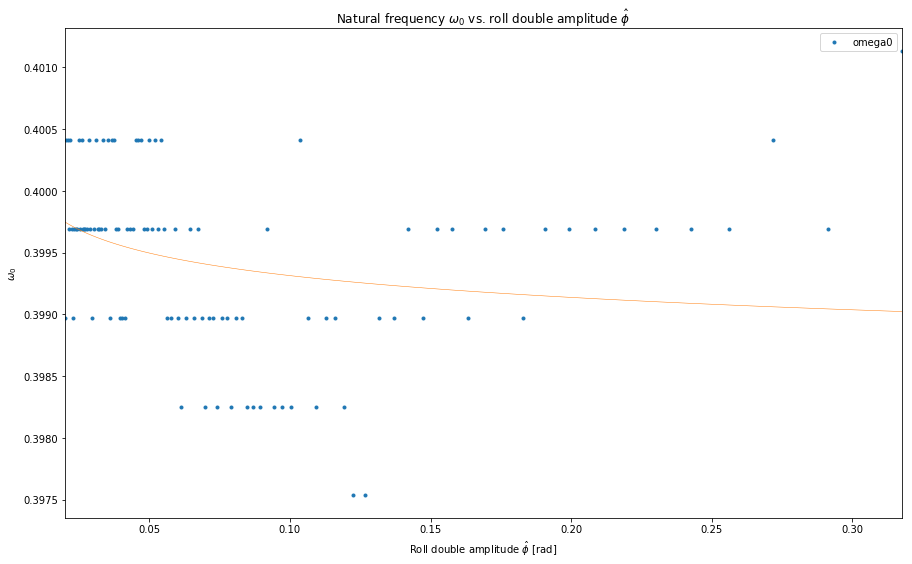

In [619]:
fig,ax=plt.subplots()
X_amplitudes = direct_linear_estimator.X_amplitudes.copy()
X_amplitudes.reset_index(inplace=True)
X_amplitudes.plot(x='phi',y='omega0', style='.', ax=ax)
ax.set_xlabel('Roll double amplitude $\hat{\phi} $ [rad]')
ax.set_ylabel('$\omega_0$')
ax.set_title('Natural frequency $ \omega_0 $ vs. roll double amplitude $\hat{\phi} $')


omega_regressor = LinearRegression()
X = pd.DataFrame()
y= X_amplitudes['omega0']
X['phi'] = X_amplitudes['phi']**(-0.05)

omega_regressor.fit(X=X,y=y)
ax.plot(X_amplitudes['phi'],omega_regressor.predict(X))

## Linear model

In [620]:
phi = df['phi']
phi1d = df['phi1d']
phi2d = df['phi2d']

X = pd.DataFrame()
X['phi1d'] = phi1d
X['phi2d'] = phi2d
#X['phi**2'] = phi**2


y = df['phi']

linear_regression1 = LinearRegression()
linear_regression1.fit(X=X,y=y)
df_prediction1 = X.copy()
df_prediction1['phi'] = linear_regression1.predict(X=X)
coefficients1 = {key:linear_regression1.coef_[i] for i,key in enumerate(X.keys())}
linear_regression1.score(X=X, y=y)

0.9997366399644173

In [621]:
coefficients1

{'phi1d': -0.08143299412698486, 'phi2d': -6.2654682797692605}

In [622]:
equations.omega_equation

Eq(omega0, -sqrt(-1/B))

In [623]:
omega0 = equations.omega_equation.rhs.subs({equations.B:coefficients1['phi2d']})
omega0

-0.399505931944423

In [624]:
equations.zeta_equation

Eq(zeta, -A*omega0/2)

In [625]:
zeta = equations.zeta_equation.rhs.subs({equations.A:coefficients1['phi1d'], symbols.omega0:omega0})
zeta

-0.0162664821048629

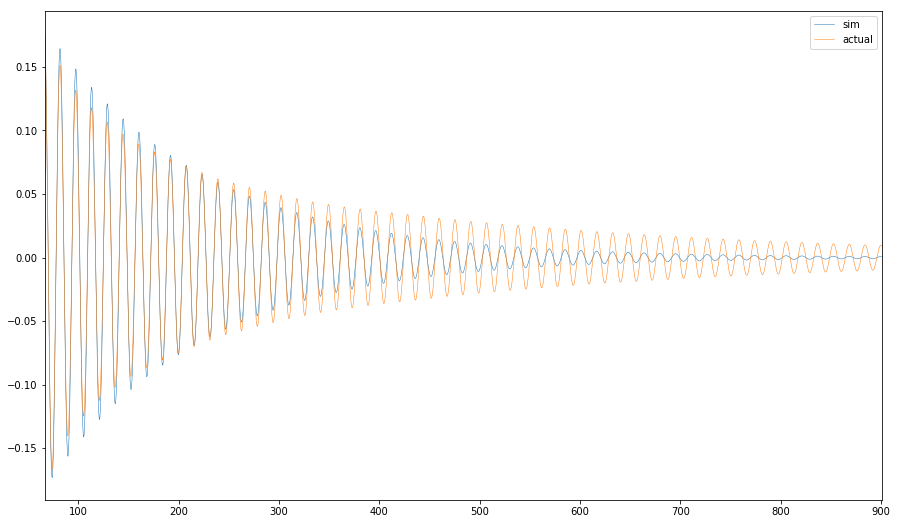

In [626]:
from rolldecayestimators import simulation_linear

phi0=df.iloc[0]['phi']
phi1d0=df.iloc[0]['phi1d']

df_sim = simulation_linear.simulate(t=df.index,phi0=phi0,phi1d0=phi1d0,omega0=float(omega0),zeta=float(zeta))

fig,ax = plt.subplots()
df_sim.plot(y='phi', ax=ax, label='sim')
df.plot(y='phi', ax=ax, label='actual')


## Quadratic model

In [627]:
phi = df['phi']
phi1d = df['phi1d']
phi2d = df['phi2d']

X = pd.DataFrame()
X['phi1d'] = phi1d
X['phi1d*|phi1d|'] = phi1d*np.abs(phi1d)
X['phi2d'] = phi2d

y = df['phi']

linear_regression2 = LinearRegression()
linear_regression2.fit(X=X,y=y)
coefficients2 = {key:linear_regression2.coef_[i] for i,key in enumerate(X.keys())}

df_prediction2 = X.copy()
df_prediction2['phi'] = linear_regression2.predict(X=X)
linear_regression2.score(X=X, y=y)

0.9999153795076215

In [628]:
coefficients2

{'phi1d': -0.014921414787650448,
 'phi1d*|phi1d|': -1.9331516166970255,
 'phi2d': -6.265295021876304}

In [629]:
omega0 = equations.omega_equation.rhs.subs({equations.B:coefficients2['phi2d']})
omega0

-0.399511455792640

In [630]:
zeta = equations.zeta_equation.rhs.subs({equations.A:coefficients2['phi1d'], symbols.omega0:omega0})
zeta

-0.00298063807215003

In [631]:
equations.d_equation

Eq(d, C/B)

In [632]:
d = equations.d_equation.rhs.subs({equations.B:coefficients2['phi2d'], equations.C:coefficients2['phi1d*|phi1d|']})
d

0.308549176047913

Text(0.5, 0, 'Time t [s] (full scale)')

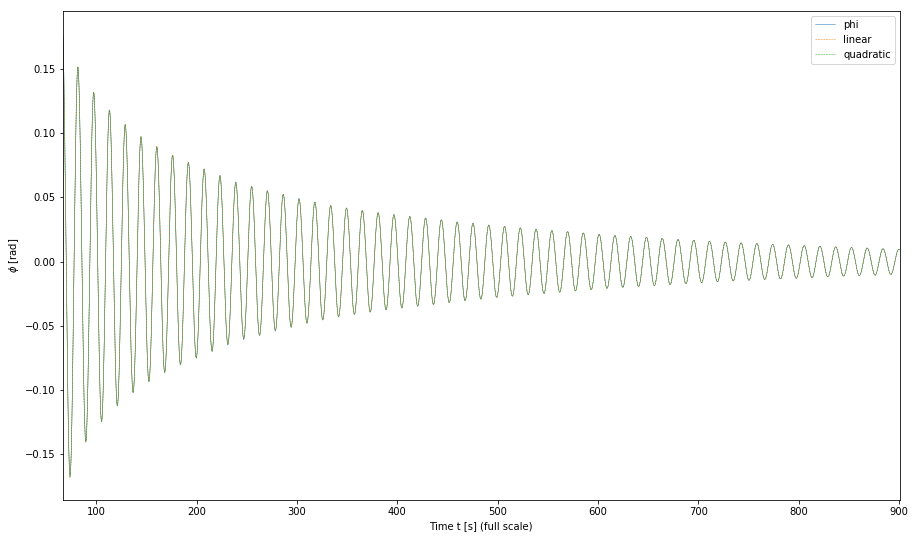

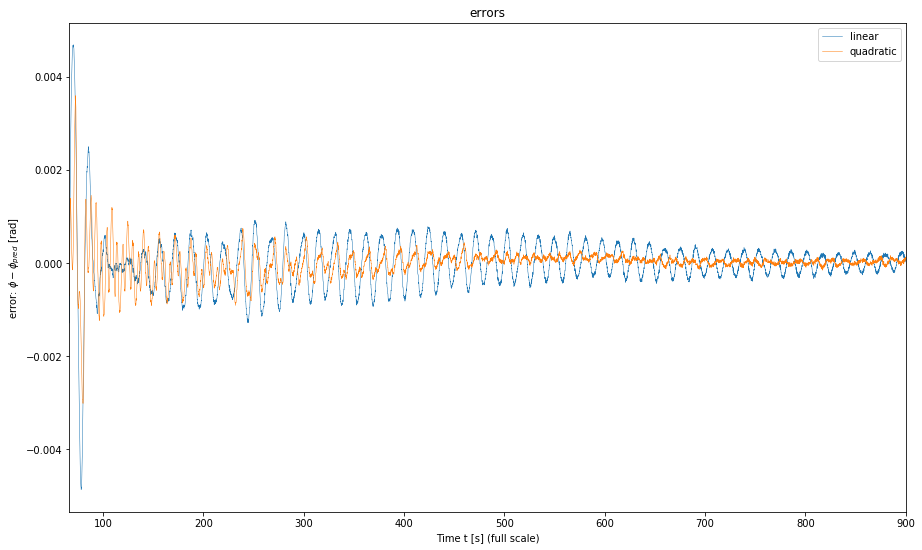

In [633]:
fig,ax = plt.subplots()
df.plot(y='phi', ax=ax)
df_prediction1.plot(y='phi', label='linear', style='--', ax=ax)
df_prediction2.plot(y='phi', label='quadratic', style='--', ax=ax)

ax.set_ylabel('$\phi$ [rad]')
ax.set_xlabel('Time t [s] (full scale)')

fig,ax = plt.subplots()
df_error1= df - df_prediction1
df_error2= df - df_prediction2
df_error1.plot(y='phi', ax=ax, label='linear')
df_error2.plot(y='phi', ax=ax, label='quadratic')
ax.set_title('errors')
ax.set_ylabel('error: $\phi-\phi_{pred}$ [rad]')
ax.set_xlabel('Time t [s] (full scale)')



In [634]:
omega0

-0.399511455792640

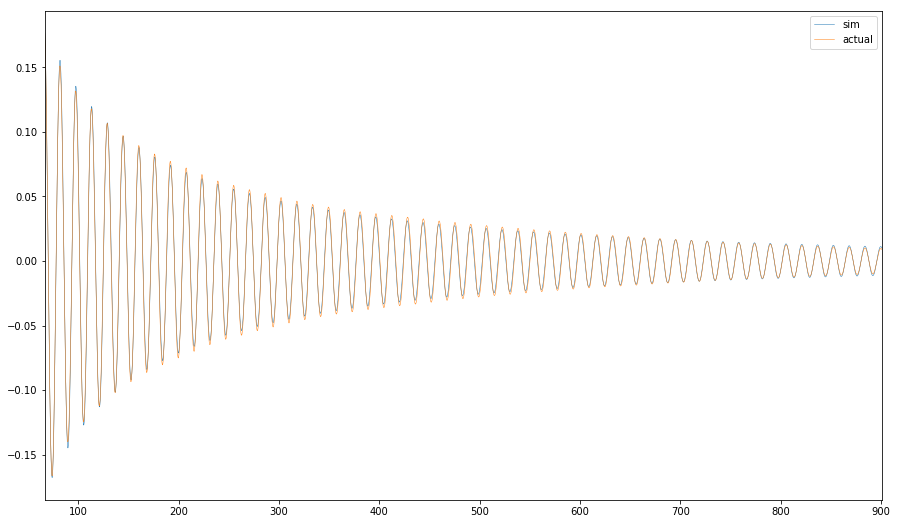

In [635]:
from rolldecayestimators import simulation

phi0=df.iloc[0]['phi']
phi1d0=df.iloc[0]['phi1d']

df_sim = simulation.simulate(t=df.index,phi0=phi0,phi1d0=phi1d0,omega0=float(omega0),zeta=float(zeta), d=float(d))

fig,ax = plt.subplots()
df_sim.plot(y='phi', ax=ax, label='sim')
df.plot(y='phi', ax=ax, label='actual')

In [636]:
direct_estimator = DirectEstimator()
direct_estimator.fit(X=df)
direct_estimator.score()

0.9960192074372675

In [637]:
direct_estimator.parameters

{'d': 0.3073492109157016,
 'omega0': 0.3994386911611813,
 'zeta': 0.003012226278470266}

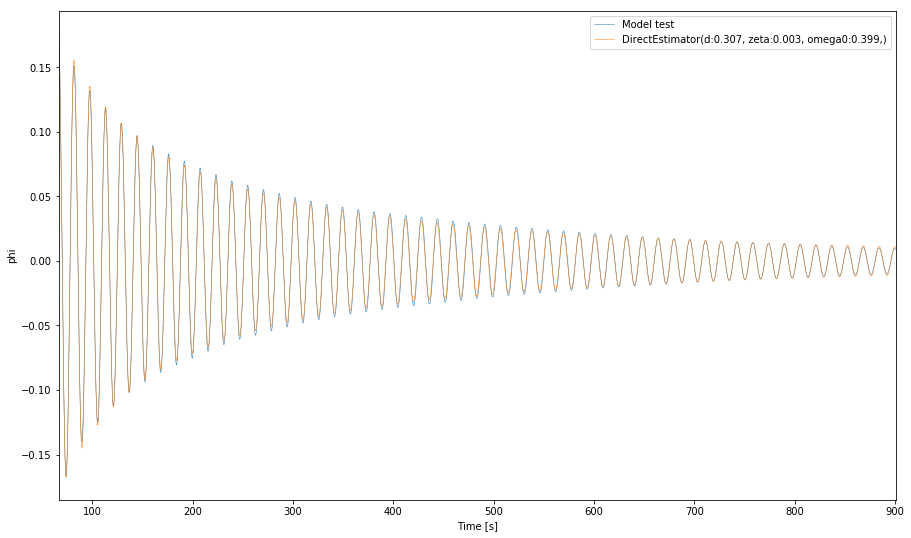

In [638]:
direct_estimator.plot_fit()